In [2]:
# Necessary imports

## Data loading, processing and for more
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE

## Visualization
import seaborn as sns
import matplotlib.pyplot as plt
# set seaborn style because it prettier
sns.set()

## Metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

## Models
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
import pickle as pkl

In [10]:
# read the data and show first 5 rows
data = pd.read_csv("../data/transaction_detail.csv")
data.head(5)

,Transaction_ID,Transaction_Amount,Transaction_Date,Transaction_Time,User_Account_ID,Account_Creation_Date,Payment_Method,Billing_Location,Shipping_Location,Device_IP_Address,Session_Duration,Frequency_of_Transactions,Time_Between_Transactions,Unusual_Time_of_Transaction,Unusual_Transaction_Amounts,IP_Address_History,Fraud_Label
0,1,1250.00,2023-05-10,18:30:00,101,2022-09-15,Credit Card,Mumbai,Mumbai,192.168.1.10,600 seconds,5,120 seconds,0,0,192.168.1.10,0
1,2,500.00,2023-05-10,12:45:00,102,2022-10-01,Debit Card,Delhi,Delhi,192.168.1.20,900 seconds,8,150 seconds,0,0,192.168.1.20,0
2,3,75340.00,2023-05-11,14:20:00,103,2022-07-05,UPI,Chennai,Pune,192.128.1.30,720 seconds,10,90 seconds,2,1,192.168.1.30,1
3,4,200.75,2023-05-12,09:15:00,104,2022-11-20,Credit Card,Bangalore,Bangalore,192.168.1.40,720 seconds,6,180 seconds,0,0,192.168.1.40,0
4,5,305.90,2023-05-13,11:30:00,105,2022-08-10,Debit Card,Kolkata,Kolkata,192.168.1.50,480 seconds,9,100 seconds,0,0,192.168.1.50,0


In [11]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Transaction_ID               64 non-null     int64  
 1   Transaction_Amount           64 non-null     float64
 2   Transaction_Date             64 non-null     object 
 3   Transaction_Time             64 non-null     object 
 4   User_Account_ID              64 non-null     int64  
 5   Account_Creation_Date        64 non-null     object 
 6   Payment_Method               64 non-null     object 
 7   Billing_Location             64 non-null     object 
 8   Shipping_Location            64 non-null     object 
 9   Device_IP_Address            64 non-null     object 
 10  Session_Duration             64 non-null     object 
 11  Frequency_of_Transactions    64 non-null     int64  
 12  Time_Between_Transactions    64 non-null     object 
 13  Unusual_Time_of_Transa

In [12]:
data_fraud = data.loc[data.Fraud_Label== 1] 
data_non_fraud = data.loc[data.Fraud_Label== 0]

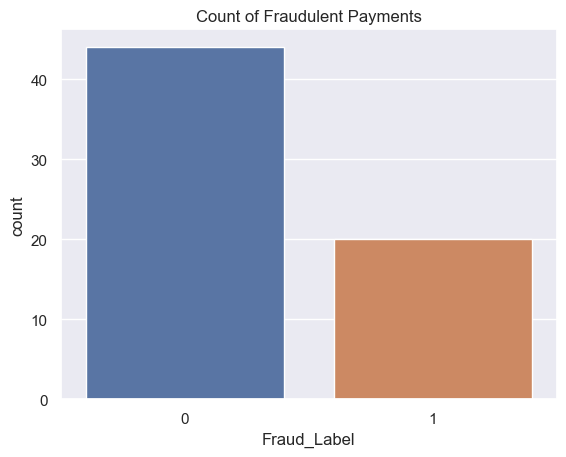

Number of normal examples:  44
Number of fradulent examples:  20


In [13]:
sns.countplot(x="Fraud_Label",data=data)
plt.title("Count of Fraudulent Payments")
plt.show()
print("Number of normal examples: ",data_non_fraud.Fraud_Label.count())
print("Number of fradulent examples: ",data_fraud.Fraud_Label.count())
#print(data.Fraud_Label.value_counts()) # does the same thing above

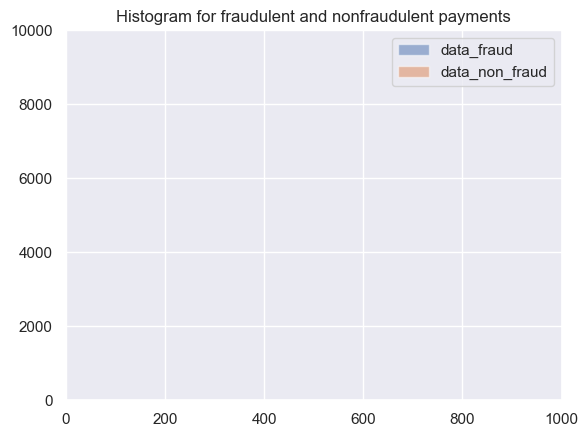

In [14]:
# Plot histograms of the amounts in fraud and non-fraud data 
plt.hist(data_fraud.Transaction_Amount, alpha=0.5, label='data_fraud',bins=100)
plt.hist(data_non_fraud.Transaction_Amount, alpha=0.5, label='data_non_fraud',bins=100)
plt.title("Histogram for fraudulent and nonfraudulent payments")
plt.ylim(0,10000)
plt.xlim(0,1000)
plt.legend()
plt.show()

In [15]:
data

,Transaction_ID,Transaction_Amount,Transaction_Date,Transaction_Time,User_Account_ID,Account_Creation_Date,Payment_Method,Billing_Location,Shipping_Location,Device_IP_Address,Session_Duration,Frequency_of_Transactions,Time_Between_Transactions,Unusual_Time_of_Transaction,Unusual_Transaction_Amounts,IP_Address_History,Fraud_Label
0,1,1250.00,2023-05-10,18:30:00,101,2022-09-15,Credit Card,Mumbai,Mumbai,192.168.1.10,600 seconds,5,120 seconds,0,0,192.168.1.10,0
1,2,500.00,2023-05-10,12:45:00,102,2022-10-01,Debit Card,Delhi,Delhi,192.168.1.20,900 seconds,8,150 seconds,0,0,192.168.1.20,0
2,3,75340.00,2023-05-11,14:20:00,103,2022-07-05,UPI,Chennai,Pune,192.128.1.30,720 seconds,10,90 seconds,2,1,192.168.1.30,1
3,4,200.75,2023-05-12,09:15:00,104,2022-11-20,Credit Card,Bangalore,Bangalore,192.168.1.40,720 seconds,6,180 seconds,0,0,192.168.1.40,0
4,5,305.90,2023-05-13,11:30:00,105,2022-08-10,Debit Card,Kolkata,Kolkata,192.168.1.50,480 seconds,9,100 seconds,0,0,192.168.1.50,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,68,13430.40,2023-07-11,01:30:00,168,2022-12-20,UPI,Mumbai,Nagpur,203.41.67.146,60 seconds,7,10 seconds,1,0,203.45.67.146,1
60,69,3445.80,2023-07-12,11:00:00,169,2022-10-05,Debit Card,Delhi,Delhi,203.45.67.147,480 seconds,10,120 seconds,0,1,203.45.67.147,0
61,70,1030.25,2023-07-13,12:15:00,170,2022-08-10,Credit Card,Chennai,Chennai,203.45.67.148,720 seconds,6,180 seconds,0,1,203.45.67.148,0
62,71,9340.75,2023-07-14,09:30:00,171,2022-09-15,UPI,Bangalore,Jaipur,203.45.67.149,600 seconds,8,150 seconds,1,0,203.41.27.149,1


In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

# Assuming your dataset is stored in a DataFrame called data

# Drop columns that might not contribute significantly to the model

data=data
# Split the dataset into features (X) and target variable (y)
X = data.drop("Fraud_Label", axis=1)
y = data["Fraud_Label"]

# Apply SMOTE for class imbalance
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

# Initialize Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

# Train the model on the training set
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print("Classification Report:")
print(classification_report(y_test, y_pred))


ValueError: could not convert string to float: '2023-05-10'

In [ ]:
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00        12

    accuracy                           1.00        18
   macro avg       1.00      1.00      1.00        18
weighted avg       1.00      1.00      1.00        18



In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'])

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


NameError: name 'y_test' is not defined

In [18]:
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]
def plot_roc_curve(y_true, y_scores, title='ROC Curve'):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curve(y_test, y_pred_prob, title='ROC Curve')


NameError: name 'rf_model' is not defined

In [19]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Transaction_ID               64 non-null     int64  
 1   Transaction_Amount           64 non-null     float64
 2   Transaction_Date             64 non-null     object 
 3   Transaction_Time             64 non-null     object 
 4   User_Account_ID              64 non-null     int64  
 5   Account_Creation_Date        64 non-null     object 
 6   Payment_Method               64 non-null     object 
 7   Billing_Location             64 non-null     object 
 8   Shipping_Location            64 non-null     object 
 9   Device_IP_Address            64 non-null     object 
 10  Session_Duration             64 non-null     object 
 11  Frequency_of_Transactions    64 non-null     int64  
 12  Time_Between_Transactions    64 non-null     object 
 13  Unusual_Time_of_Transa

In [20]:
import pickle as pkl
def save_model_to_pickle(model, filename):
    with open(filename, 'wb') as file:
        pkl.dump(model, file)

# Example usage:
save_model_to_pickle(rf_model, 'random_forest_model.pkl')

NameError: name 'rf_model' is not defined

In [21]:
new_input = {
    'Transaction_Amount': 150.0,
    'User_Account_ID': 105,
    'Payment_Method': 'Credit Card',
    'Billing_Location': 'New York',
    'Shipping_Location': 'New York',
    'Device_IP_Address': '192.168.1.20',
    'Session_Duration': '300 seconds',
    'Frequency_of_Transactions': 3,
    'Time_Between_Transactions': '180 seconds',
    'Unusual_Time_of_Transaction': 0,
    'Unusual_Transaction_Amounts': 0,
    'IP_Address_History': '192.168.1.20'
}

for key, value in new_input.items():
    print(f"{key}: {type(value)}")


Transaction_Amount: <class 'float'>
User_Account_ID: <class 'int'>
Payment_Method: <class 'str'>
Billing_Location: <class 'str'>
Shipping_Location: <class 'str'>
Device_IP_Address: <class 'str'>
Session_Duration: <class 'str'>
Frequency_of_Transactions: <class 'int'>
Time_Between_Transactions: <class 'str'>
Unusual_Time_of_Transaction: <class 'int'>
Unusual_Transaction_Amounts: <class 'int'>
IP_Address_History: <class 'str'>


In [ ]:
def encode_input(input_data):
    encoded_data = input_data.copy()

    # Define encoding mappings if needed
    payment_method_mapping = {'Credit Card': 0, 'UPI': 1, 'Other': 2}
    location_mapping = {'New York': 0, 'Mumbai': 1, 'Chennai': 2, 'Pune': 3, 'Other': 4}

    # Encode Payment_Method
    encoded_data['Payment_Method'] = payment_method_mapping.get(encoded_data['Payment_Method'], -1)

    # Encode Billing_Location and Shipping_Location
    encoded_data['Billing_Location'] = location_mapping.get(encoded_data['Billing_Location'], -1)
    encoded_data['Shipping_Location'] = location_mapping.get(encoded_data['Shipping_Location'], -1)

    # You may add more encoding for other categorical variables if needed

    # Convert Session_Duration and Time_Between_Transactions to integers
    encoded_data['Session_Duration'] = int(encoded_data['Session_Duration'].split()[0])
    encoded_data['Time_Between_Transactions'] = int(encoded_data['Time_Between_Transactions'].split()[0])

    return encoded_data

# Example usage:
encoded_input = encode_input(new_input)
print(encoded_input)
#print datatypes of encoded_input
for key in encoded_input:
    print (key + " : " + str(type(encoded_input[key])))
    



{'Transaction_Amount': 150.0, 'User_Account_ID': 105, 'Payment_Method': 0, 'Billing_Location': 0, 'Shipping_Location': 0, 'Device_IP_Address': '192.168.1.20', 'Session_Duration': 300, 'Frequency_of_Transactions': 3, 'Time_Between_Transactions': 180, 'Unusual_Time_of_Transaction': 0, 'Unusual_Transaction_Amounts': 0, 'IP_Address_History': '192.168.1.20'}
Transaction_Amount : <class 'float'>
User_Account_ID : <class 'int'>
Payment_Method : <class 'int'>
Billing_Location : <class 'int'>
Shipping_Location : <class 'int'>
Device_IP_Address : <class 'str'>
Session_Duration : <class 'int'>
Frequency_of_Transactions : <class 'int'>
Time_Between_Transactions : <class 'int'>
Unusual_Time_of_Transaction : <class 'int'>
Unusual_Transaction_Amounts : <class 'int'>
IP_Address_History : <class 'str'>


In [ ]:
def load_model_from_pickle(filename):
    with open(filename, 'rb') as file:
        model = pkl.load(file)
    return model

In [ ]:
loaded_rf_model = load_model_from_pickle('random_forest_model.pkl')
